<a href="https://colab.research.google.com/github/Rawan-Ahmed-Mohamed/nlp_text_classification/blob/main/project_NLP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install -q wordcloud gradio joblib

In [16]:
#imports + data
import re, os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from keras.layers import Input

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gradio as gr

# 20newsgroups
categories = ['sci.med', 'sci.space']
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers','footers','quotes'))
df = pd.DataFrame({'text': data.data, 'label': data.target})
label_map = {0: 'Medical', 1: 'Space'}
df['label_name'] = df['label'].map(label_map)
print("Loaded dataset shape:", df.shape)


Loaded dataset shape: (1977, 3)


label_name
Medical    990
Space      987
Name: count, dtype: int64
Text length stats:
 count    1977.000000
mean      195.024279
std       481.887303
min         0.000000
25%        45.000000
50%        89.000000
75%       176.000000
max      9113.000000
Name: text_len, dtype: float64


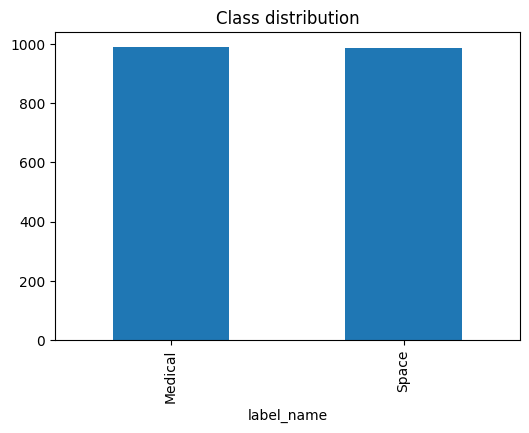

Top 20 words: [('the', 19135), ('and', 8538), ('that', 4504), ('for', 3875), ('this', 2573), ('you', 2532), ('are', 2462), ('with', 2206), ('have', 2174), ('not', 1988), ('was', 1743), ('from', 1648), ('but', 1590), ('can', 1400), ('they', 1335), ('space', 1304), ('there', 1226), ('about', 1178), ('would', 1155), ('one', 1129)]


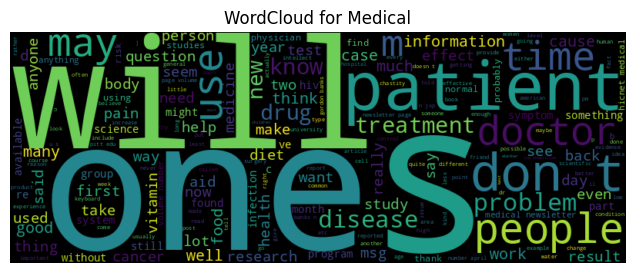

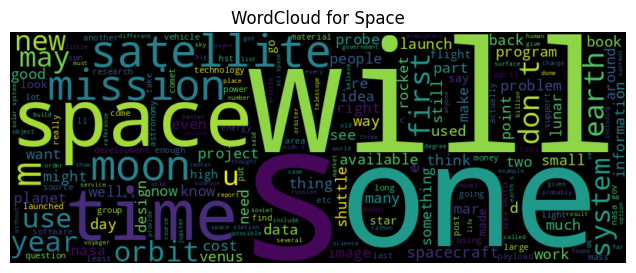

In [17]:
print(df['label_name'].value_counts())
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
print("Text length stats:\n", df['text_len'].describe())

plt.figure(figsize=(6,4))
df['label_name'].value_counts().plot(kind='bar')
plt.title("Class distribution")
plt.show()

def simple_tokenize(txt):
    txt = re.sub(r'[^a-zA-Z\s]', ' ', str(txt))
    return [t for t in txt.lower().split() if len(t)>2]

all_words = []
df['text'].apply(lambda x: all_words.extend(simple_tokenize(x)))
from collections import Counter
print("Top 20 words:", Counter(all_words).most_common(20))

for lbl in df['label'].unique():
    txt = " ".join(df[df['label']==lbl]['text'].astype(str).values)
    wc = WordCloud(width=800, height=300).generate(re.sub(r'[^a-zA-Z\s]', ' ', txt.lower()))
    plt.figure(figsize=(10,3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {label_map[lbl]}")
    plt.show()


In [18]:
# Preprocessing
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
X = df['clean_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train / Test sizes:", len(X_train), len(X_test))


Train / Test sizes: 1581 396


In [19]:
def unit_tests_preprocessing():
    assert df['clean_text'].isnull().sum() == 0, "Nulls in clean_text!"
    assert len(" ".join(df['clean_text'].tolist()).split()) > 50, "Text seems too short!"
    print("Unit tests passed: preprocessing OK ✅")

unit_tests_preprocessing()


Unit tests passed: preprocessing OK ✅


In [20]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))

pipe_lr = Pipeline([('tfidf', tfidf), ('clf', LogisticRegression(max_iter=200, random_state=42))])
pipe_svm = Pipeline([('tfidf', tfidf), ('clf', SVC(kernel='linear', probability=True, random_state=42))])

from sklearn.model_selection import GridSearchCV
print("GridSearch LR...")
params_lr = {'clf__C': [0.1, 1, 5]}
gs_lr = GridSearchCV(pipe_lr, params_lr, cv=3, scoring='f1', n_jobs=2)
gs_lr.fit(X_train, y_train)
print("LR best:", gs_lr.best_params_)

print("GridSearch SVM...")
params_svm = {'clf__C': [0.1, 1]}
gs_svm = GridSearchCV(pipe_svm, params_svm, cv=3, scoring='f1', n_jobs=2)
gs_svm.fit(X_train, y_train)
print("SVM best:", gs_svm.best_params_)


GridSearch LR...
LR best: {'clf__C': 5}
GridSearch SVM...
SVM best: {'clf__C': 1}


In [21]:
MAX_WORDS = 10000
MAX_LEN = 200
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Tokenizer vocab size:", len(tokenizer.word_index))
print("Train pad shape:", X_train_pad.shape)


Tokenizer vocab size: 22281
Train pad shape: (1581, 200)


In [22]:
def build_lstm_model(vocab_size=MAX_WORDS, embed_dim=64, lstm_units=64):
    model = Sequential([
        Input(shape=(MAX_LEN,)),
        Embedding(input_dim=vocab_size, output_dim=embed_dim),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
chkpt_path = "best_lstm.h5"
mc = ModelCheckpoint(chkpt_path, monitor='val_loss', save_best_only=True)

history = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.15,
    epochs=10,
    batch_size=64,
    callbacks=[es, mc],
    verbose=1
)

lstm_model = load_model(chkpt_path)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,177 (2.69 MB)

 Trainable params: 706,177 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5215 - loss: 0.6933

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.5217 - loss: 0.6933 - val_accuracy: 0.5210 - val_loss: 0.6886
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.6192 - loss: 0.6741

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.6190 - loss: 0.6738 - val_accuracy: 0.7227 - val_loss: 0.6432
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7740 - loss: 0.6197

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 332ms/step - accuracy: 0.7744 - loss: 0.6187 - val_accuracy: 0.7773 - val_loss: 0.5438
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8652 - loss: 0.4118

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.8656 - loss: 0.4091 - val_accuracy: 0.8824 - val_loss: 0.3053
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9308 - loss: 0.2157

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 324ms/step - accuracy: 0.9310 - loss: 0.2152 - val_accuracy: 0.9118 - val_loss: 0.2011
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9436 - loss: 0.1418

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 0.9439 - loss: 0.1416 - val_accuracy: 0.9244 - val_loss: 0.1730
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9728 - loss: 0.0864

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9728 - loss: 0.0859 - val_accuracy: 0.9412 - val_loss: 0.1552
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 274ms/step - accuracy: 0.9706 - loss: 0.0674 - val_accuracy: 0.9244 - val_loss: 0.1776
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 331ms/step - accuracy: 0.9765 - loss: 0.0589 - val_accuracy: 0.9118 - val_loss: 0.2005
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9817 - loss: 0.0624

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.9816 - loss: 0.0622 - val_accuracy: 0.9454 - val_loss: 0.1282


=== LogisticRegression_TFIDF ===
              precision    recall  f1-score   support

     Medical       0.95      0.88      0.92       198
       Space       0.89      0.95      0.92       198

    accuracy                           0.92       396
   macro avg       0.92      0.92      0.92       396
weighted avg       0.92      0.92      0.92       396

Confusion matrix:
 [[175  23]
 [  9 189]]

=== SVM_TFIDF ===
              precision    recall  f1-score   support

     Medical       0.94      0.88      0.91       198
       Space       0.89      0.94      0.91       198

    accuracy                           0.91       396
   macro avg       0.91      0.91      0.91       396
weighted avg       0.91      0.91      0.91       396

Confusion matrix:
 [[174  24]
 [ 11 187]]

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
=== LSTM ===
              precision    recall  f1-score   support

     Medical       0.95      0.83      0.89       198
       Space       0.85      0.96      0.90    

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_TFIDF,0.919192,0.891509,0.954545,0.921951,0.977247
1,SVM_TFIDF,0.911616,0.886256,0.944444,0.914425,0.974416
2,LSTM,0.896465,0.852018,0.959596,0.902613,0.961484


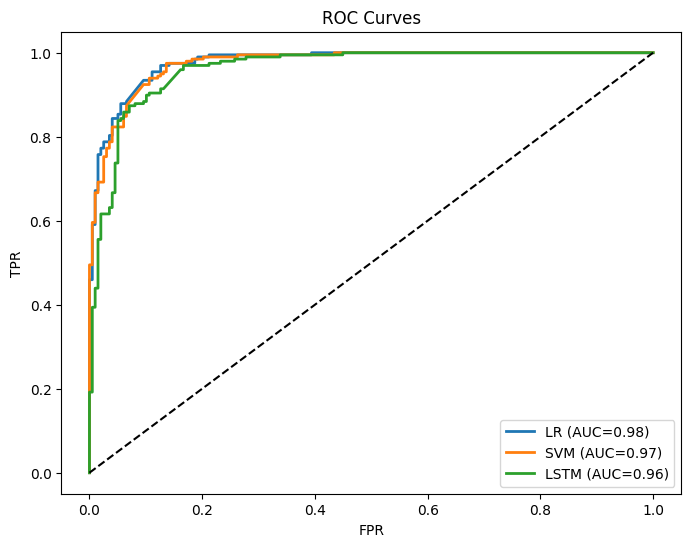

In [23]:
results = []
def eval_and_store(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    results.append({'model':name,'accuracy':acc,'precision':prec,'recall':rec,'f1':f1,'roc_auc':roc})
    print(f"=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=['Medical','Space']))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print()

# LR
y_pred_lr = gs_lr.predict(X_test)
y_proba_lr = gs_lr.predict_proba(X_test)[:,1]
eval_and_store('LogisticRegression_TFIDF', y_test, y_pred_lr, y_proba_lr)

# SVM
y_pred_svm = gs_svm.predict(X_test)
y_proba_svm = gs_svm.predict_proba(X_test)[:,1]
eval_and_store('SVM_TFIDF', y_test, y_pred_svm, y_proba_svm)

# LSTM
y_proba_lstm = lstm_model.predict(X_test_pad).ravel()
y_pred_lstm = (y_proba_lstm > 0.5).astype(int)
eval_and_store('LSTM', y_test, y_pred_lstm, y_proba_lstm)

results_df = pd.DataFrame(results).sort_values('f1', ascending=False)
results_df.to_csv("model_comparison_results.csv", index=False)
display(results_df)

plt.figure(figsize=(8,6))
for name, y_t, y_p in [('LR', y_test, y_proba_lr), ('SVM', y_test, y_proba_svm), ('LSTM', y_test, y_proba_lstm)]:
    fpr, tpr, _ = roc_curve(y_t, y_p)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc(fpr,tpr):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves')
plt.show()


In [24]:
# Save + tokenizer
os.makedirs('models', exist_ok=True)
joblib.dump(gs_lr.best_estimator_, 'models/logreg_tfidf.pkl')
joblib.dump(gs_svm.best_estimator_, 'models/svm_tfidf.pkl')
lstm_model.save('models/lstm_model.keras')
joblib.dump(tokenizer, 'models/tokenizer.pkl')
print("Saved models to /models")


Saved models to /models


In [25]:
def unit_tests():
    assert df['clean_text'].isnull().sum() == 0, "Nulls in clean_text!"
    assert len(tokenizer.word_index) > 100, "Tokenizer vocab too small"
    m1 = joblib.load('models/logreg_tfidf.pkl')
    p1 = m1.predict_proba(["this is a test about Medical"])[:,1]
    assert p1.shape[0] == 1
    m2 = load_model('models/lstm_model.keras', compile=False)
    seq = pad_sequences(tokenizer.texts_to_sequences(["this is a test about space"]), maxlen=MAX_LEN)
    p2 = m2.predict(seq)
    assert p2.shape == (1,1)
    print("All unit tests passed!")

unit_tests()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
All unit tests passed!


In [26]:
# Load saved models and tokenizer
loaded_lr = joblib.load('models/logreg_tfidf.pkl')
loaded_svm = joblib.load('models/svm_tfidf.pkl')
loaded_lstm = load_model('models/lstm_model.keras', compile=False)
tok = joblib.load('models/tokenizer.pkl')

# Prediction function for Gradio interface
def predict_text(text, model_choice='LogisticRegression_TFIDF'):
    text_clean = clean_text(text)
    if model_choice == 'LogisticRegression_TFIDF':
        proba = loaded_lr.predict_proba([text_clean])[:,1][0]
        label = 'Space' if proba > 0.5 else 'Medical'
        return label, float(proba)
    elif model_choice == 'SVM_TFIDF':
        proba = loaded_svm.predict_proba([text_clean])[:,1][0]
        label = 'Space' if proba > 0.5 else 'Medical'
        return label, float(proba)
    else:
        seq = pad_sequences(tok.texts_to_sequences([text_clean]), maxlen=MAX_LEN)
        proba = loaded_lstm.predict(seq)[0][0]
        label = 'Space' if proba > 0.5 else 'Medical'
        return label, float(proba)

# Create Gradio interface
iface = gr.Interface(
    fn=predict_text,
    inputs=[
        gr.Textbox(lines=4, placeholder="Enter your text here..."),
        gr.Dropdown(['LogisticRegression_TFIDF','SVM_TFIDF','LSTM'], value='LogisticRegression_TFIDF')
    ],
    outputs=[
        gr.Textbox(label="Predicted Label"),
        gr.Number(label="Confidence (Probability of Space)")
    ],
    title="News Category Classifier",
    description="Select a model and input text to classify it as 'Space' or 'Medical'."
)

# Launch the interface
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e8428c4c1adac0320f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
